In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 548 kB/s 


In [2]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn
import torch.nn.init as init

In [9]:
def _weights_init(m):
  classname = m.__class__.__name
  if isinstance(m,nn.Linear) or isinstance(m,nn.Conv3d):
    init.kaiming_normal(m.weight)
class Residual(nn.Module):
  def __init__(self,fn):
    super().init__()
    self.fn = fn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
# 等于 PreNorm
class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
# 等于 FeedForward
class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim,dim*3,bias=True)
        self.nn1 = nn.Linear(dim,dim)
        self.do1 = nn.Dropout(dropout)
    def forward(self,x,mask=None):
      b, n, _, h = *x.shape, self.heads
      qkv = self.to_qkv(x).chunk(3,dim=-1)
      q,k,v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)# split into multi head attentions

      dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
      mask_value = -torch.finfo(dots.dtype).max
      if mask is not None:
        mask = F.pad(mask.flatten(1), (1, 0), value=True)
        assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
        mask = mask[:, None, :] * mask[:, :, None]
        dots.masked_fill_(~mask, float('-inf'))
        del mask
      attn = dots.softmax(dim=-1)
      out = torch.einsum('bhij,bhjd->bhid', attn, v)
      out = rearrange(out, 'b h n d -> b n (h d)')
      out = self.nn1(out)
      out = self.do1(out)
      return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads=heads, dropout=dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        for attention, mlp in self.layers:
            x = attention(x, mask=mask)  # go to attention
            x = mlp(x)  # go to MLP_Block
        return x

NUM_CLASS = 16
class SSFTTnet(nn.Module):
    def __init__(self, in_channels=1, num_classes=NUM_CLASS, num_tokens=4, dim=64, depth=1, heads=8, mlp_dim=8, dropout=0.1, emb_dropout=0.1):
      super(SSFTTnet, self).__init__()
      self.L = num_tokens  #即输入的影像数据经过EMBD转化为tokek的个数，在本实例中设为4
      self.ct = dim
      self.conv3d_features = nn.Sequential(
          nn.Conv3d(in_channels, out_channels=8, kernel_size=(3, 3, 3)),
          nn.BatchNorm3d(8),
          nn.ReLU(),
      )
      self.conv2d_features = nn.Sequential(
          nn.Conv2d(in_channels=8*28, out_channels=64, kernel_size=(3, 3)),
          nn.BatchNorm2d(64),
          nn.ReLU(), 
      )
      # Tokenization
      self.token_wA = nn.Parameter(torch.empty(1,self.L,64),requires_grad=True)# Tokenization parameters (1,4,64)
      torch.nn.init.xavier_normal_(self.token_wA)
      self.token_wV = nn.Parameter(torch.empty(1,64,self.ct),requires_grad=True)# Tokenization parameters
      torch.nn.init.xavier_normal_(self.token_wV)

      self.pos_embedding = nn.Parameter(torch.empty(1,(num_tokens+1),dim))
      torch.nn.init.normal_(self.pos_embedding, std=.02)
      self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
      self.dropout = nn.Dropout(emb_dropout)
      self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
      self.to_cls_token = nn.Identity()#???????????????????????
      self.nn1 = nn.Linear(dim, num_classes)
      torch.nn.init.xavier_uniform_(self.nn1.weight)
      torch.nn.init.normal_(self.nn1.bias, std=1e-6)
    def forward(self, x, mask=None):
      print("输入数据的x.shape:",x.shape)
      #  A. Spectral–Spatial Feature Extraction
      x = self.conv3d_features(x)
      x = rearrange(x, 'b c h w y -> b (c h) w y')
      x = self.conv2d_features(x)
      x = rearrange(x,'b c h w -> b (h w) c')
      print("在卷积处理后的x.shape:",x.shape)

      #  将经过卷积处理的输入数据生成token!!!!!!!!!!!!!!!!
      wa = rearrange(self.token_wA, 'b h w -> b w h')#(1,64,4)
      print("wa.shape:",wa.shape)
      A = torch.einsum('bij,bjk->bik', x, wa)
      print("A.shape:",A.shape)
      A = rearrange(A, 'b h w -> b w h')  # Transpose
      print("after transpose A.shape:",A.shape)
      A = A.softmax(dim=-1)
      print("after softmax A.shape:",A.shape)
      VV = torch.einsum('bij,bjk->bik', x, self.token_wV)
      print("self.token_wV.shape:",self.token_wV.shape)
      print("VV.shape:",VV.shape)
      T = torch.einsum('bij,bjk->bik', A, VV)
      print("T.shape:",T.shape)
      #print("T.shape:",T.shape)

      #主体传播
      cls_tokens = self.cls_token.expand(x.shape[0],-1,-1)
      print("after cls_tokens x.shape:",cls_tokens.shape)
      x = torch.cat((cls_tokens, T), dim=1)
      print("after cat x.shape:",x.shape)
      x += self.pos_embedding
      x = self.dropout(x)
      x = self.transformer(x, mask)  # main game
      x = self.to_cls_token(x[:, 0])
      x = self.nn1(x)
      return x

In [10]:
if __name__ == '__main__':
    model = SSFTTnet()
    model.eval()
    #print(model)
    input = torch.randn(1, 1, 30, 13, 13)
    y = model(input)
    print(y.size())

输入数据的x.shape: torch.Size([1, 1, 30, 13, 13])
在卷积处理后的x.shape: torch.Size([1, 81, 64])
wa.shape: torch.Size([1, 64, 4])
A.shape: torch.Size([1, 81, 4])
after transpose A.shape: torch.Size([1, 4, 81])
after softmax A.shape: torch.Size([1, 4, 81])
self.token_wV.shape: torch.Size([1, 64, 64])
VV.shape: torch.Size([1, 81, 64])
T.shape: torch.Size([1, 4, 64])
after cls_tokens x.shape: torch.Size([1, 1, 64])
after cat x.shape: torch.Size([1, 5, 64])
torch.Size([1, 16])


In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import torch
import torch.nn as nn
import torch.optim as optim
from operator import truediv
import time

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 13, 13, 30)
Data cube y shape:  (145, 145)

... ... create train & test data ... ...
Xtrain shape:  (1024, 13, 13, 30)
Xtest  shape:  (9225, 13, 13, 30)
before transpose: Xtrain shape:  (1024, 13, 13, 30, 1)
before transpose: Xtest  shape:  (9225, 13, 13, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 13, 13)
after transpose: Xtest  shape:  (9225, 1, 30, 13, 13)
[Epoch: 1]   [loss avg: 29.0866]   [current loss: 1.2049]
[Epoch: 2]   [loss avg: 20.6221]   [current loss: 0.3940]
[Epoch: 3]   [loss avg: 15.4728]   [current loss: 0.4008]
[Epoch: 4]   [loss avg: 12.3181]   [current loss: 0.0614]
[Epoch: 5]   [loss avg: 10.3240]   [current loss: 0.0578]
[Epoch: 6]   [loss avg: 8.8709]   [current loss: 0.0615]
[Epoch: 7]   [loss avg: 7.7232]   [current loss: 0.0624]
[Epoch: 8]   [loss av

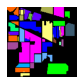

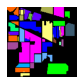

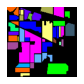

In [ ]:
#加载数据
def loadData():
    # 读入数据
    data = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_gt.mat')['indian_pines_gt']

    return data, labels
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X,numComponents):
  newX = np.reshape(X, (-1, X.shape[2]))
  pca = PCA(n_components=numComponents, whiten=True)
  newX = pca.fit_transform(newX)
  newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
  return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData,patchesLabels

#划分数据集
def splitTrainTestSet(X, y, testRatio, randomState=345):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testRatio,random_state=randomState,stratify=y)
  return X_train, X_test, y_train, y_test

BATCH_SIZE_TRAIN = 64
def create_data_loader():
    # 地物类别
    # class_num = 16
    # 读入数据
    X, y = loadData()
    # 用于测试样本的比例
    test_ratio = 0.90
    # 每个像素周围提取 patch 的尺寸
    patch_size = 13
    # 使用 PCA 降维，得到主成分的数量
    pca_components = 30

    print('Hyperspectral data shape: ', X.shape)
    print('Label shape: ', y.shape)

    print('\n... ... PCA tranformation ... ...')
    X_pca = applyPCA(X, numComponents=pca_components)
    print('Data shape after PCA: ', X_pca.shape)

    print('\n... ... create data cubes ... ...')
    X_pca, y_all = createImageCubes(X_pca, y, windowSize=patch_size)
    print('Data cube X shape: ', X_pca.shape)
    print('Data cube y shape: ', y.shape)

    print('\n... ... create train & test data ... ...')
    Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y_all, test_ratio)
    print('Xtrain shape: ', Xtrain.shape)
    print('Xtest  shape: ', Xtest.shape)

    # 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
    X = X_pca.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtest = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
    print('before transpose: Xtrain shape: ', Xtrain.shape)
    print('before transpose: Xtest  shape: ', Xtest.shape)

    # 为了适应 pytorch 结构，数据要做 transpose
    X = X.transpose(0, 4, 3, 1, 2)
    Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
    Xtest = Xtest.transpose(0, 4, 3, 1, 2)
    print('after transpose: Xtrain shape: ', Xtrain.shape)
    print('after transpose: Xtest  shape: ', Xtest.shape)

    # 创建train_loader和 test_loader
    X = TestDS(X, y_all)
    trainset = TrainDS(Xtrain, ytrain)
    testset = TestDS(Xtest, ytest)
    train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=BATCH_SIZE_TRAIN,shuffle=True,num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=BATCH_SIZE_TRAIN,shuffle=True,num_workers=0)
    all_data_loader = torch.utils.data.DataLoader(dataset=X,batch_size=BATCH_SIZE_TRAIN,shuffle=False,num_workers=0)
    return train_loader, test_loader, all_data_loader, y

#Training dataset
class TrainDS(torch.utils.data.Dataset):
  def __init__(self,Xtrain,ytrain):
    super().__init__()
    self.len = Xtrain.shape[0]
    self.x_data = torch.FloatTensor(Xtrain)
    self.y_data = torch.LongTensor(ytrain)
  def __getitem__(self,index):
    #根据索引返回数据和对应的标签
    return self.x_data[index], self.y_data[index]
  def __len__(self):
    #返回文件数
    return self.len
""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self, Xtest, ytest):
        super().__init__()
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

# 使用GPU训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train(train_loader,epochs):
  # 网络放到GPU上
  net = SSFTTnet().to(device)
  # 交叉熵损失函数
  criterion = nn.CrossEntropyLoss()
  # 初始化优化器
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  # 开始训练
  total_loss = 0
  for epoch in range(epochs):
    net.train()
    for i,(data,target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      outputs = net(data)
      loss = criterion(outputs,target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' % (epoch + 1, total_loss / (epoch + 1),loss.item()))
  print('Finished Training')
  return net, device

def test(device, net, test_loader):
  count = 0
  net.eval()
  y_pred_test= 0
  y_test = 0
  for inputs,labels in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
      y_pred_test = outputs
      y_test = labels
      count = 1
    else:
      y_pred_test = np.concatenate((y_pred_test, outputs))
      y_test = np.concatenate((y_test, labels))
  return y_pred_test, y_test

def AA_andEachClassAccuracy(confusion_matrix):
  list_diag = np.diag(confusion_matrix)
  list_raw_sum = np.sum(confusion_matrix, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  average_acc = np.mean(each_acc)
  return each_acc, average_acc

def acc_reports(y_test, y_pred_test):
  target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
        , 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']
  classification = classification_report(y_test, y_pred_test, digits=4, target_names=target_names)
  oa = accuracy_score(y_test, y_pred_test)
  confusion = confusion_matrix(y_test, y_pred_test)
  each_acc, aa = AA_andEachClassAccuracy(confusion)
  kappa = cohen_kappa_score(y_test, y_pred_test)
  return classification, oa*100, confusion, each_acc*100, aa*100, kappa*100

if __name__ == '__main__':
  train_loader, test_loader, all_data_loader, y_all= create_data_loader()
  tic1 = time.perf_counter()
  net, device = train(train_loader, epochs=100)
  # 只保存模型参数
  torch.save(net.state_dict(), 'SSFTTnet_params.pth')
  toc1 = time.perf_counter()
  tic2 = time.perf_counter()
  y_pred_test, y_test = test(device, net, test_loader)
  toc2 = time.perf_counter()
  # 评价指标
  classification, oa, confusion, each_acc, aa, kappa = acc_reports(y_test, y_pred_test)
  classification = str(classification)
  Training_Time = toc1 - tic1
  Test_time = toc2 - tic2
  file_name = "/content/drive/MyDrive/AI data/classification_report.txt"
  with open(file_name, 'w') as x_file:
    x_file.write('{} Training_Time (s)'.format(Training_Time))
    x_file.write('\n')
    x_file.write('{} Test_time (s)'.format(Test_time))
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{} Each accuracy (%)'.format(each_acc))
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))
  get_cls_map=get_cls_map(net, device, all_data_loader, y_all)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def get_classification_map(y_pred, y):
  height = y.shape[0]
  width = y.shape[1]
  k = 0
  cls_labels = np.zeros((height, width))
  for i in range(height):
    for j in range(width):
      target = int(y[i,j])
      if target == 0:
        continue
      else:
        cls_labels[i][j] = y_pred[k]+1
        k += 1
  return cls_labels

def list_to_colormap(x_list):
    y = np.zeros((x_list.shape[0], 3))
    for index, item in enumerate(x_list):
        if item == 0:
            y[index] = np.array([0, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([147, 67, 46]) / 255.
        if item == 2:
            y[index] = np.array([0, 0, 255]) / 255.
        if item == 3:
            y[index] = np.array([255, 100, 0]) / 255.
        if item == 4:
            y[index] = np.array([0, 255, 123]) / 255.
        if item == 5:
            y[index] = np.array([164, 75, 155]) / 255.
        if item == 6:
            y[index] = np.array([101, 174, 255]) / 255.
        if item == 7:
            y[index] = np.array([118, 254, 172]) / 255.
        if item == 8:
            y[index] = np.array([60, 91, 112]) / 255.
        if item == 9:
            y[index] = np.array([255, 255, 0]) / 255.
        if item == 10:
            y[index] = np.array([255, 255, 125]) / 255.
        if item == 11:
            y[index] = np.array([255, 0, 255]) / 255.
        if item == 12:
            y[index] = np.array([100, 0, 255]) / 255.
        if item == 13:
            y[index] = np.array([0, 172, 254]) / 255.
        if item == 14:
            y[index] = np.array([0, 255, 0]) / 255.
        if item == 15:
            y[index] = np.array([171, 175, 80]) / 255.
        if item == 16:
            y[index] = np.array([101, 193, 60]) / 255.

    return y
def classification_map(map,ground_truth,dpi,save_path):
  fig = plt.figure(frameon=False)
  fig.set_size_inches(ground_truth.shape[1]*2.0/dpi, ground_truth.shape[0]*2.0/dpi)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  fig.add_axes(ax)
  ax.imshow(map)
  fig.savefig(save_path, dpi=dpi)
  return 0
def test(device, net, test_loader):
    count = 0
    # 模型测试
    net.eval()
    y_pred_test = 0
    y_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred_test = outputs
            y_test = labels
            count = 1
        else:
            y_pred_test = np.concatenate((y_pred_test, outputs))
            y_test = np.concatenate((y_test, labels))

    return y_pred_test, y_test

def get_cls_map(net,device,all_data_loader,y):
  y_pred, y_new = test(device, net, all_data_loader)
  cls_labels = get_classification_map(y_pred, y)
  x = np.ravel(cls_labels)
  gt = y.flatten()
  y_list = list_to_colormap(x)
  y_gt = list_to_colormap(gt)
  y_re = np.reshape(y_list, (y.shape[0], y.shape[1], 3))
  gt_re = np.reshape(y_gt, (y.shape[0], y.shape[1], 3))
  classification_map(y_re,y,300,'/content/drive/MyDrive/AI data/classification_maps/' + 'IP_predictions.eps')
  classification_map(y_re, y, 300,'/content/drive/MyDrive/AI data/classification_maps/' + 'IP_predictions.png')
  classification_map(gt_re, y, 300,'/content/drive/MyDrive/AI data/classification_maps/' + 'IP_gt.png')
  print('------Get classification maps successful-------')